In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from xml.etree import ElementTree as ET
def collect_instance_data(xml_string):
    def _recurse(data, current_path, xml_element):
        current_path = current_path + '/' + xml_element.tag
        if len(xml_element) == 0:
            if current_path not in data:
                data[current_path] = []
            data[current_path].append(xml_element.text)
        else:    
            for child in xml_element:
                _recurse(data, current_path, child)
    data = {}
    xml_tree = ET.fromstring(xml_string)
    _recurse(data, '', xml_tree)
    return data

This function takes an XML document string and returns a dictionary that has tags (in a path like string) as keys and a list of texts in each occurance of that tag

In [3]:
def get_features(xml):
    data_as_dict = collect_instance_data(xml)
    df = pd.DataFrame(data_as_dict)
    df = df.melt(var_name='tag', value_name='item')
    return df

This function coverts the dictionary from collect_instane data to a DataFrame that can be passed to supervised learning models

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

def create_pipeline(model):            
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 2), lowercase=False)
    classifier = model if model != None else DecisionTreeClassifier(random_state=42)
    pipeline = make_pipeline(vectorizer, classifier)
    return pipeline
    

def compare_xmls(xml1, xml2, model):
    xml1_data = collect_instance_data(xml1)
    xml1_features = get_features(xml1)
    xml2_data = collect_instance_data(xml2)
    pipeline = create_pipeline(model)
    pipeline.fit(xml1_features['item'], xml1_features['tag'])

    output_shape =len(xml2_data.keys()), len(xml1_data.keys())
    outputs = pd.DataFrame(np.zeros(output_shape),
        index=xml2_data.keys(), columns=xml1_data.keys())
    
    for tag in xml2_data:
        predictions = pipeline.predict(xml2_data[tag])
        total = len(predictions)
        for p in predictions:
            outputs.loc[tag, p] += 1.0 / total
    return outputs

# Metrics helpers

In [5]:
from sklearn.metrics import f1_score, log_loss

In [6]:
def log_loss_from_result(result_matrix):
    expected = np.identity(len(result_matrix))
    return log_loss(expected, result_matrix)

In [7]:
def f1_score_from_result(result_matrix):
    selection = np.argmax(result_matrix.values, axis=1)
    expected = np.arange(0, len(result_matrix))
    return f1_score(expected, selection, average='micro')

<h1>Testing With Countries Data</h1>

In [8]:
countries_xmls = []
for i in range(2):
    filename = 'data/countries_' + str(i + 1) + '.xml'
    with open(filename) as file:
        countries_xmls.append(file.read())

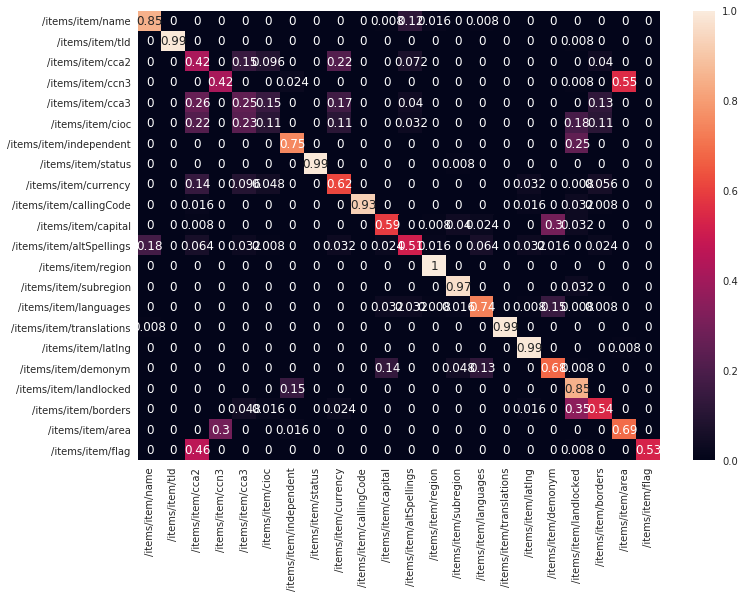

In [9]:
countries_results = compare_xmls(countries_xmls[1], countries_xmls[0], model=None)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(countries_results, annot=True)

In [10]:
log_loss_from_result(countries_results)

0.4574829623674748

In [11]:
f1_score_from_result(countries_results)

0.8636363636363636

<h1>Countries XML with Naive Bayes</h1>

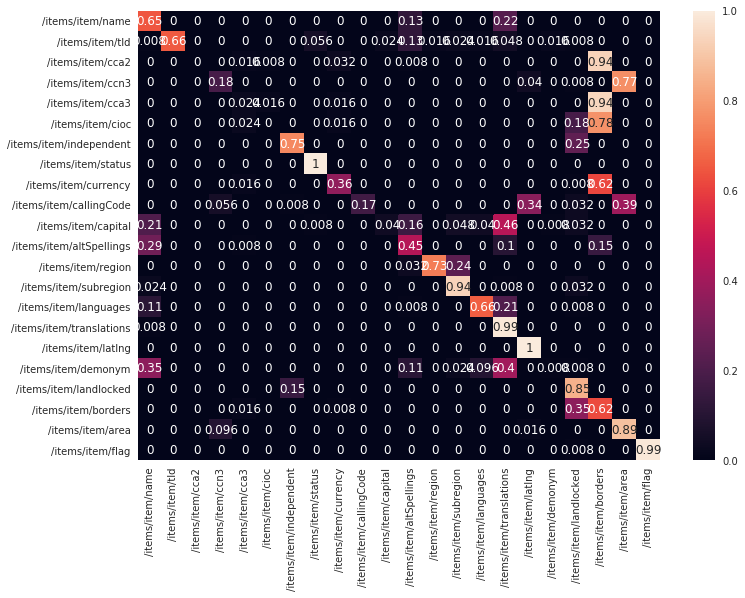

In [12]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
countries_nb_results = compare_xmls(countries_xmls[1], countries_xmls[0], model=model)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(countries_nb_results, annot=True)

In [13]:
log_loss_from_result(countries_nb_results)

4.039115479061864

In [14]:
f1_score_from_result(countries_nb_results)

0.6363636363636364

# Countries with Random Forest 

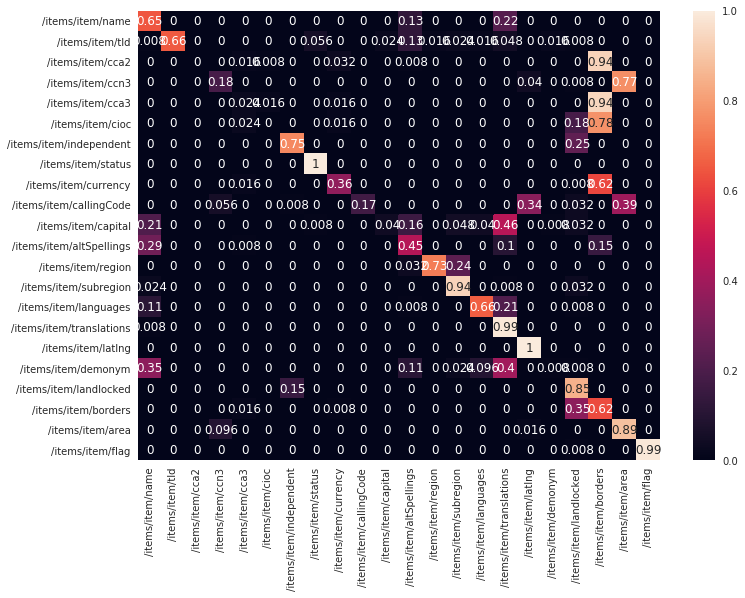

In [15]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42)
countries_forest_results = compare_xmls(countries_xmls[1], countries_xmls[0], model=model)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(countries_nb_results, annot=True)

In [16]:
log_loss_from_result(countries_forest_results)

0.43473285329481093

In [17]:
f1_score_from_result(countries_forest_results)

0.9090909090909091

<h1>Countries XML With LogisticRegression</h1>

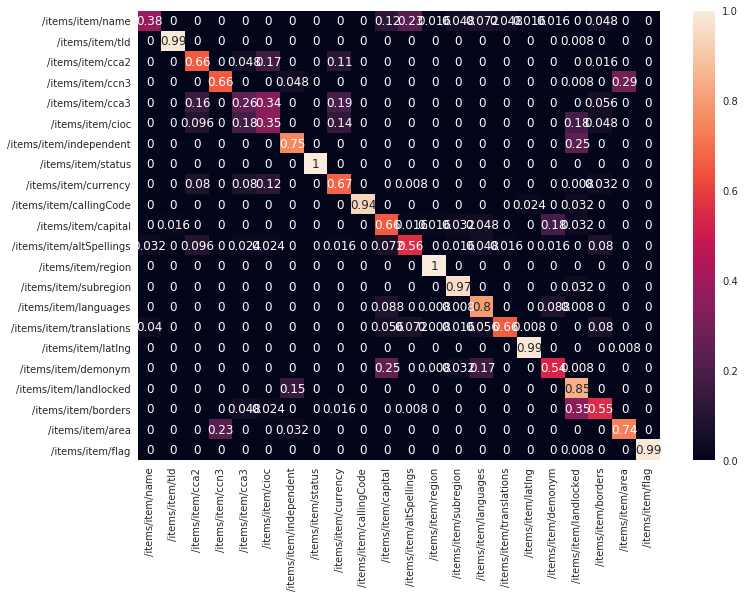

In [18]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
countries_lr_results = compare_xmls(countries_xmls[1], countries_xmls[0], model=model)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(countries_lr_results, annot=True)

In [19]:
log_loss_from_result(countries_lr_results)

0.3785011898933433

In [20]:
f1_score_from_result(countries_lr_results)

0.9545454545454546

In [21]:
def heatmap_and_errors(results):
    print(log_loss_from_result(results), f1_score_from_result(results))
    sns.heatmap(results, annot=True)

# Titanic XML with DecisionTree

In [22]:
!ls data

countries_1.xml  seattle_3.xml	ted_1.xml  ted_5.xml  ted_9.xml
countries_2.xml  seattle_4.xml	ted_2.xml  ted_6.xml  titanic_1.xml
seattle_1.xml	 seattle_5.xml	ted_3.xml  ted_7.xml  titanic_2.xml
seattle_2.xml	 ted_10.xml	ted_4.xml  ted_8.xml


In [23]:
filenames = ['data/titanic_1.xml', 'data/titanic_2.xml']
xmls = []
for filename in filenames:
    with open(filename) as file:
        xmls.append(file.read())

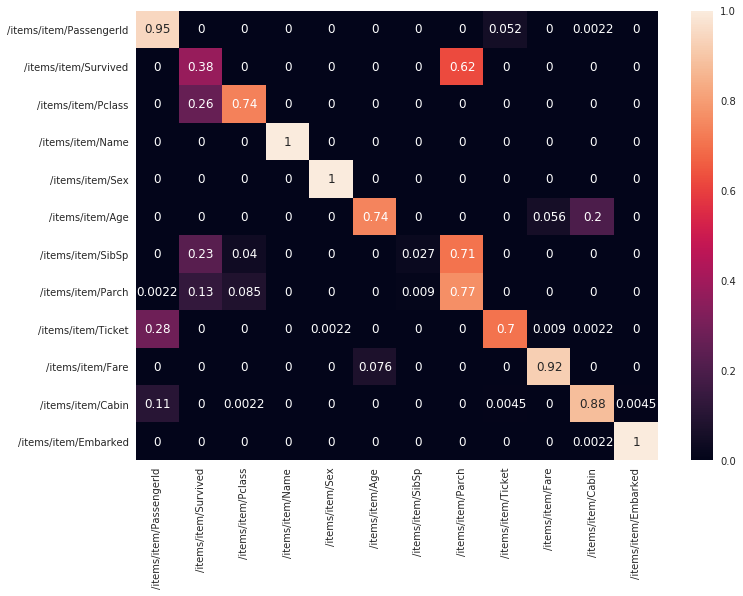

In [24]:
titanic_results = compare_xmls(xmls[0], xmls[1], model=None)
sns.heatmap(titanic_results, annot=True)

In [25]:
log_loss_from_result(titanic_results)

0.5061153331410411

In [26]:
f1_score_from_result(titanic_results)

0.8333333333333334

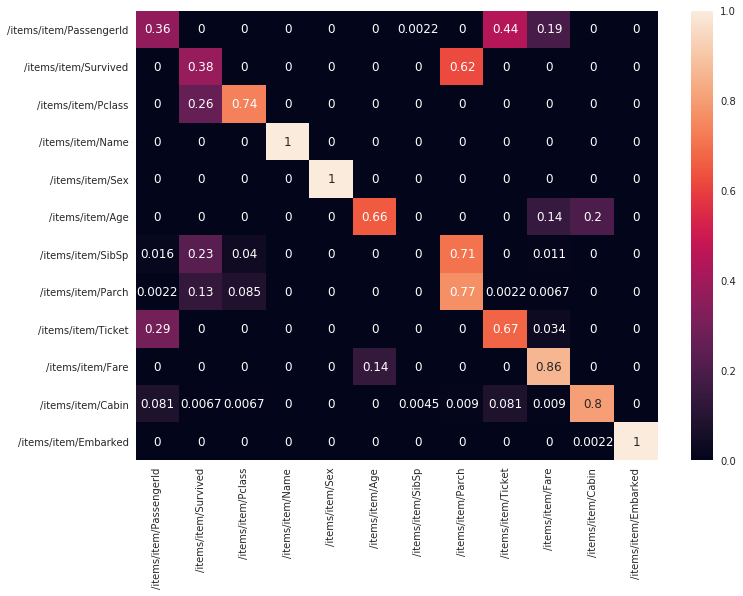

In [27]:
titanic_nb_results = compare_xmls(xmls[0], xmls[1], model=MultinomialNB())
sns.heatmap(titanic_nb_results, annot=True)

In [28]:
log_loss_from_result(titanic_nb_results)

3.190552514071042

In [29]:
f1_score_from_result(titanic_nb_results)

0.75

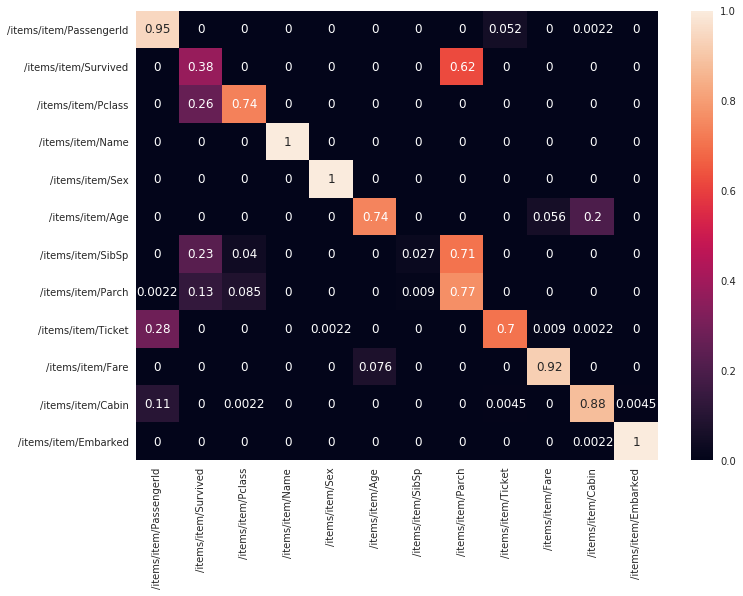

In [30]:
titanic_forest_results = compare_xmls(xmls[0], xmls[1], model=RandomForestClassifier(random_state=42))
sns.heatmap(titanic_results, annot=True)

In [31]:
f1_score_from_result(titanic_forest_results)

0.8333333333333334

In [32]:
log_loss_from_result(titanic_forest_results)

0.5044327782749861

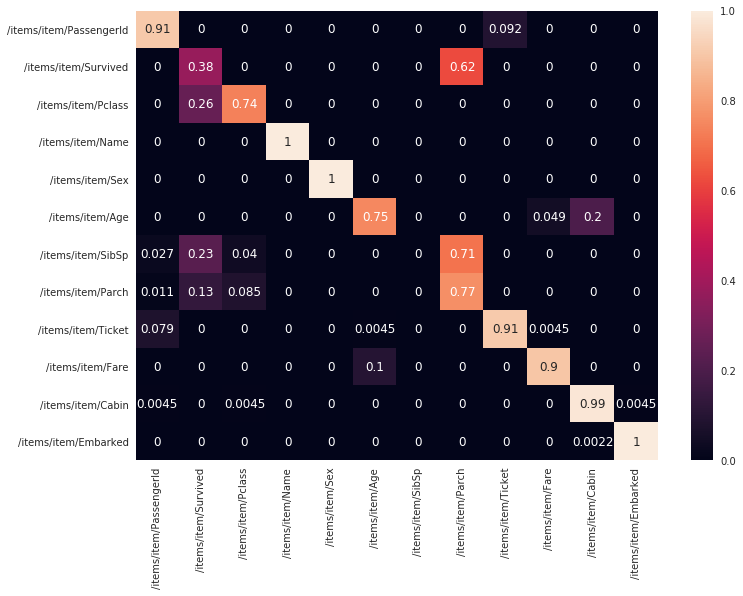

In [33]:
titanic_lr_results = compare_xmls(xmls[0], xmls[1], model=LogisticRegression())
sns.heatmap(titanic_lr_results, annot=True)

In [34]:
log_loss_from_result(titanic_lr_results), f1_score_from_result(titanic_lr_results)

(3.0570774352823755, 0.8333333333333334)

# Seattle Weather Data

In [35]:
get_file_name = lambda index: 'data/seattle_' + str(index) + '.xml'
weather_xmls = []
for i in range(1, 6):
    file = get_file_name(i)
    with open(file) as xml:
        weather_xmls.append(xml.read())

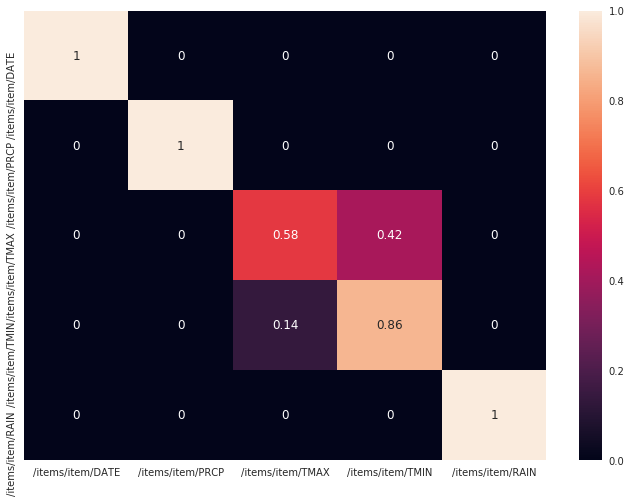

In [36]:
seattle_result = compare_xmls(weather_xmls[0], weather_xmls[1], model=None)
sns.heatmap(seattle_result, annot=True)

In [37]:
log_loss_from_result(seattle_result)

0.1374090906093213

In [38]:
f1_score_from_result(seattle_result)

1.0

0.1374997935587217 1.0


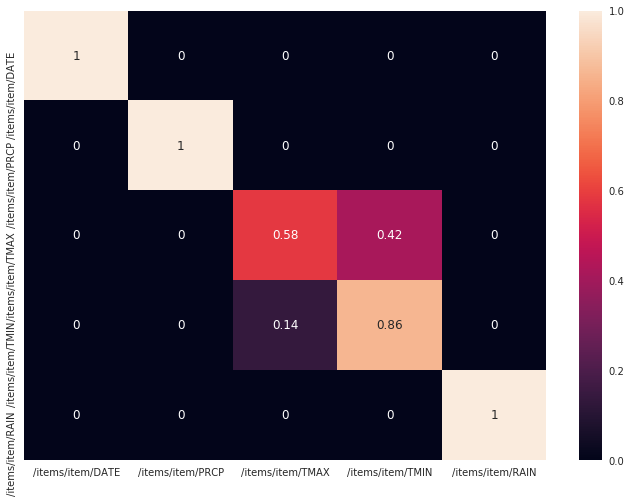

In [39]:
heatmap_and_errors(compare_xmls(weather_xmls[0], weather_xmls[1], model=LogisticRegression()))

0.1374090906093213 1.0


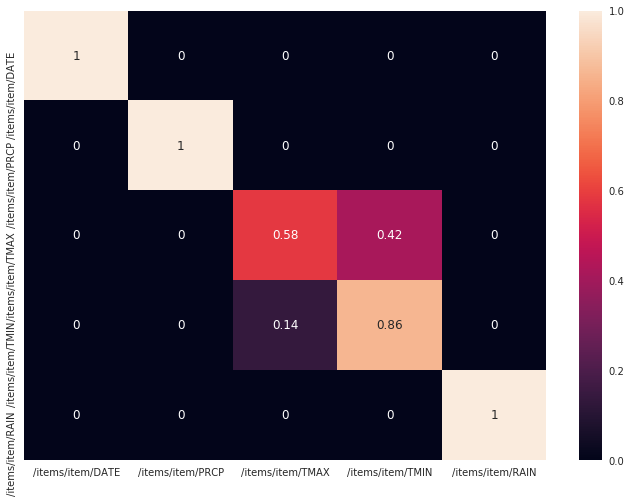

In [40]:
heatmap_and_errors(compare_xmls(weather_xmls[0], weather_xmls[1], model=RandomForestClassifier(random_state=42)))

#  TED data

In [41]:
get_file_name = lambda index: 'data/ted_' + str(index) + '.xml'
ted_xmls = []
for i in range(1, 11):
    file = get_file_name(i)
    with open(file) as xml:
        ted_xmls.append(xml.read())

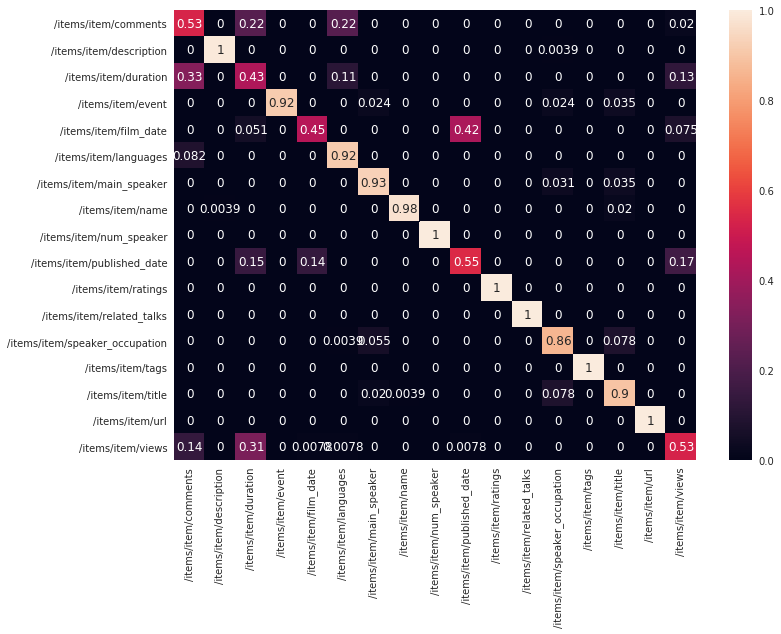

In [42]:
ted_result = compare_xmls(ted_xmls[0], ted_xmls[1], model=None)
sns.heatmap(ted_result, annot=True)

In [43]:
log_loss_from_result(ted_result), f1_score_from_result(ted_result)

(0.23677225548148145, 1.0)

0.2550360215504377 0.8823529411764706


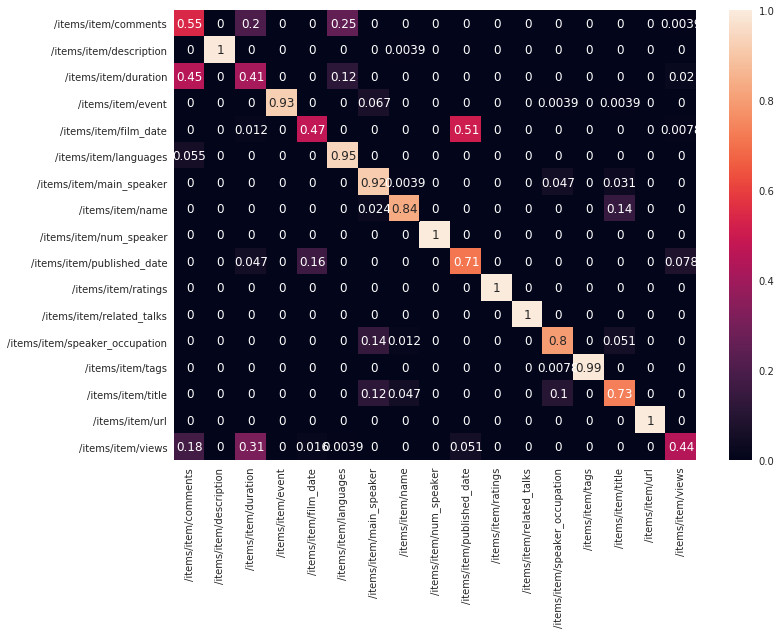

In [44]:
heatmap_and_errors(compare_xmls(ted_xmls[0], ted_xmls[1], model=RandomForestClassifier(random_state=42)))

0.17806377208542856 1.0


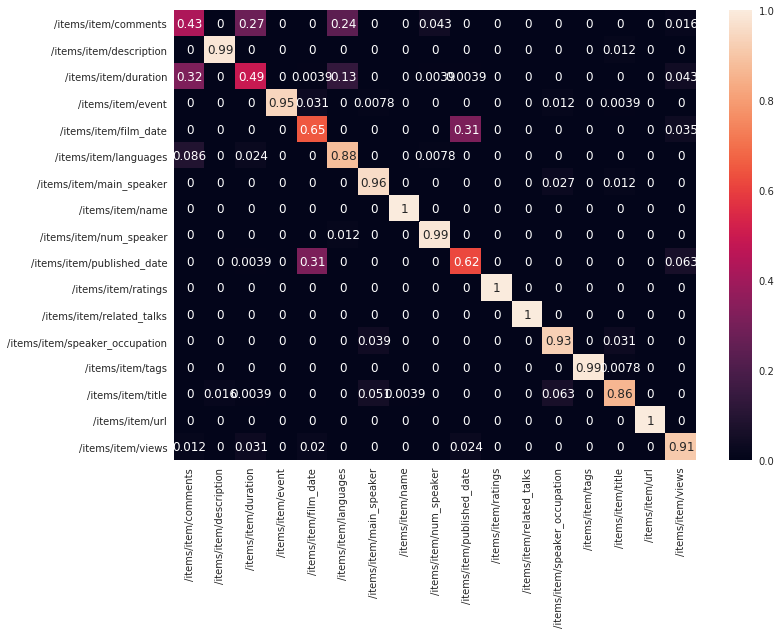

In [45]:
heatmap_and_errors(compare_xmls(ted_xmls[0], ted_xmls[1], model=LogisticRegression()))